In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from lib.database.database_connector import DatabaseConnector
from IPython.display import display

In [2]:
db = DatabaseConnector("./data/database.db")
cursor = db.cursor

rows = cursor.execute("""
    SELECT filing_date, label, sentences
    FROM embeddings
""").fetchall()

df = pd.DataFrame(rows, columns=["filing_date","merge_label","sentences"])
df['sentences'] = df['sentences'].apply(lambda x: json.loads(x))
# df['embeddings'] = df['embeddings'].apply(lambda x: json.loads(x))
df['sentences_list'] = df['sentences'].copy()
df['sentences'] = df['sentences'].apply(lambda x: " ".join(x))
df["filing_date"] = pd.to_datetime(df["filing_date"])
df["year"] = df["filing_date"].dt.year
df["word_count"] = df["sentences"].str.split().apply(len)
df['sentence_count'] = df['sentences_list'].apply(len)


In [3]:
df.head()

,filing_date,merge_label,sentences,sentences_list,year,word_count,sentence_count
0,2010-12-20,1,Item 7. Management's Discussion and Analysis o...,"[Item 7., Management's Discussion and Analysis...",2010,269,4
1,2010-09-07,0,# ITEM 2. MANAGEMENTS DISCUSSION AND ANALYSIS...,"[# ITEM 2., MANAGEMENTS DISCUSSION AND ANALYS...",2010,10288,339
2,2010-06-07,0,# ITEM 2. MANAGEMENTS DISCUSSION AND ANALYSIS...,"[# ITEM 2., MANAGEMENTS DISCUSSION AND ANALYS...",2010,9560,331
3,2010-03-10,0,# ITEM 2. MANAGEMENTS DISCUSSION AND ANALYSIS...,"[# ITEM 2., MANAGEMENTS DISCUSSION AND ANALYS...",2010,8829,320
4,2010-10-27,0,Item 7. Managements Discussion and Analysis o...,"[Item 7., Managements Discussion and Analysis...",2010,9576,311


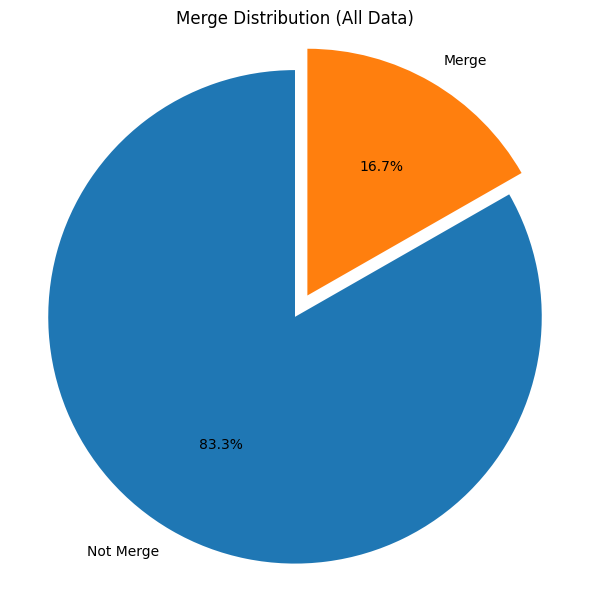

In [4]:
df_train = df[df['year'] < 2019]

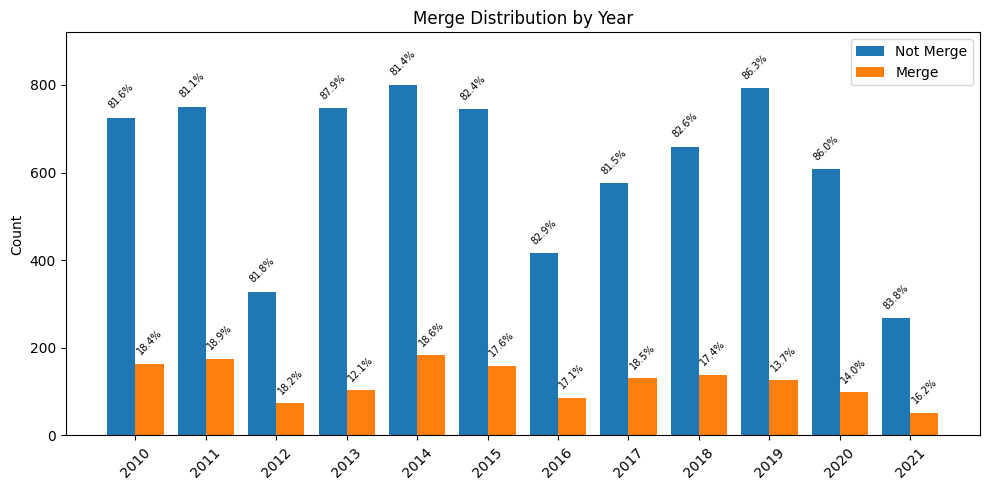

In [5]:
len(df_train[df_train["merge_label"] == 0])

In [6]:
counts = df["merge_label"].value_counts().sort_index()
labels = ["Not Merge", "Merge"]
plt.figure(figsize=(6,6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, explode=(0.05,0.05))
plt.title("Merge Distribution (All Data)")
plt.axis('equal')
plt.tight_layout()
plt.show()

,All Data,Merge Cases,Not-Merge Cases
Count,8905,1490,7415
Merge Ratio,100.0%,16.7%,83.3%
Avg Word Count,10138.445255,10209.227517,10124.221982
Word Count Std,8477.434065,8201.49488,8532.273746
Avg Sentences Count,307.103874,310.891275,306.342819
Sentences Count Std,255.729119,255.582216,255.769088


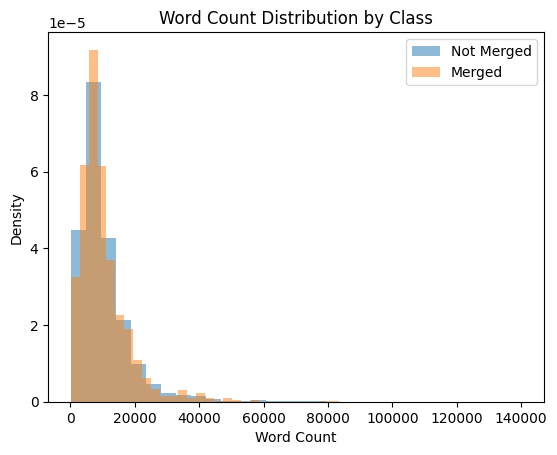

In [7]:
yearly = df.groupby(["year","merge_label"]).size().unstack(fill_value=0)
years = yearly.index.values
not_merge = yearly[0].values
merge     = yearly[1].values
yearly_totals = yearly.sum(axis=1).values


x = np.arange(len(years))
width = 0.4

fig, ax = plt.subplots(figsize=(10,5))
bars1 = ax.bar(x - width/2, not_merge, width, label="Not Merge")
bars2 = ax.bar(x + width/2,     merge, width, label="Merge")

ax.set_xticks(x)
ax.set_xticklabels(years, rotation=45)
ax.set_ylabel("Count")
ax.set_title("Merge Distribution by Year")
ax.legend()

# Üst sınırı ayarla: en yüksek çubuk yüksekliğinin %15 fazlası
max_bar = max(not_merge.max(), merge.max())
ax.set_ylim(0, max_bar * 1.15)

# Yüzdelik etiketlerini ekle
for bars, values in zip((bars1, bars2), (not_merge, merge)):
    for bar, value, total in zip(bars, values, yearly_totals):
        perc = value / total * 100
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            value + max_bar * 0.02,    # çubuğun üstüne küçük bir offset
            f'{perc:.1f}%',
            ha='center',
            va='bottom',
            rotation=45,
            fontsize=7,
        )

plt.tight_layout()
plt.show()

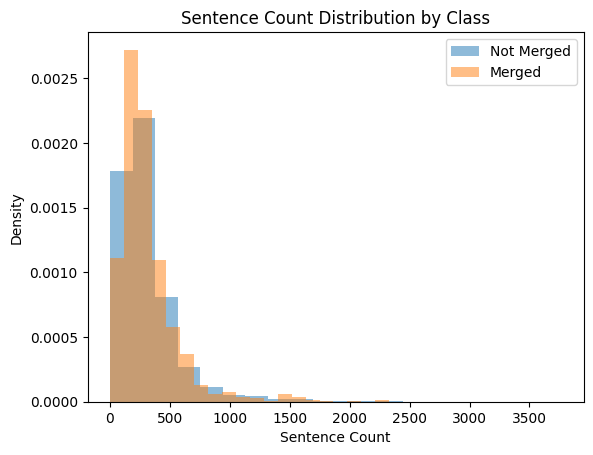

In [9]:
total         = len(df)
merge_cnt     = int(df["merge_label"].sum())
not_merge_cnt = total - merge_cnt
merge_pct     = merge_cnt/total*100
not_merge_pct = not_merge_cnt/total*100

merge_df     = df[df["merge_label"]==1]
not_merge_df = df[df["merge_label"]==0]



stats = pd.DataFrame({
    "All Data": [
        total,
        f"{100:.1f}%",
        df["word_count"].mean(),
        df["word_count"].std(),
        df["sentence_count"].mean(),
        df["sentence_count"].std()
    ],
    "Merge Cases": [
        merge_cnt,
        f"{merge_pct:.1f}%",
        merge_df["word_count"].mean(),
        merge_df["word_count"].std(),
        merge_df["sentence_count"].mean(),
        merge_df["sentence_count"].std()
    ],
    "Not-Merge Cases": [
        not_merge_cnt,
        f"{not_merge_pct:.1f}%",
        not_merge_df["word_count"].mean(),
        not_merge_df["word_count"].std(),
        not_merge_df["sentence_count"].mean(),
        not_merge_df["sentence_count"].std()
    ]
}, index=[
    "Count",
    "Merge Ratio",
    "Avg Word Count",
    "Word Count Std",
    "Avg Sentences Count",
    "Sentences Count Std"
])

display(stats)


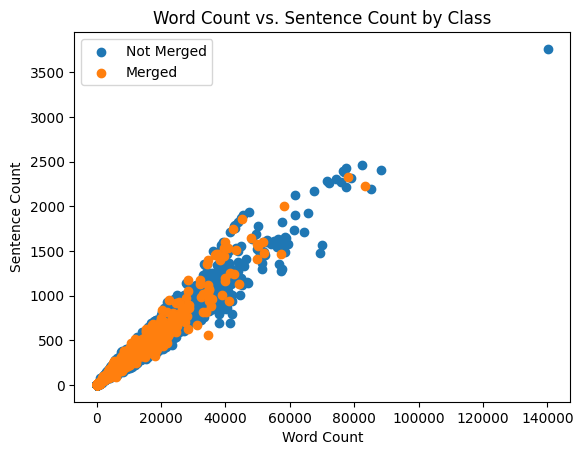

In [10]:
plt.figure()
plt.hist(
    df.loc[df.merge_label==0, 'word_count'],
    bins=30, alpha=0.5, density=True, label='Not Merged'
)
plt.hist(
    df.loc[df.merge_label==1, 'word_count'],
    bins=30, alpha=0.5, density=True, label='Merged'
)
plt.xlabel('Word Count')
plt.ylabel('Density')
plt.title('Word Count Distribution by Class')
plt.legend()
plt.show()

In [12]:
plt.figure()
plt.hist(
    df.loc[df.merge_label==0, 'sentence_count'],
    bins=20, alpha=0.5, density=True, label='Not Merged'
)
plt.hist(
    df.loc[df.merge_label==1, 'sentence_count'],
    bins=20, alpha=0.5, density=True, label='Merged'
)
plt.xlabel('Sentence Count')
plt.ylabel('Density')
plt.title('Sentence Count Distribution by Class')
plt.legend()
plt.show()

          feature  hist_intersection  bhattacharyya_coeff  percent_overlap
0      word_count           0.976972             0.998244            97.70
1  sentence_count           0.961691             0.997238            96.17


In [ ]:
plt.figure()
plt.scatter(
    df.loc[df.merge_label==0, 'word_count'],
    df.loc[df.merge_label==0, 'sentence_count'],
    label='Not Merged'
)
plt.scatter(
    df.loc[df.merge_label==1, 'word_count'],
    df.loc[df.merge_label==1, 'sentence_count'],
    label='Merged'
)
plt.xlabel('Word Count')
plt.ylabel('Sentence Count')
plt.title('Word Count vs. Sentence Count by Class')
plt.legend()
plt.show()

In [ ]:
def histogram_intersection(p, q, bins=30):
    counts_p, bin_edges = np.histogram(p, bins=bins, density=True)
    counts_q, _ = np.histogram(q, bins=bin_edges, density=True)
    return np.sum(np.minimum(counts_p, counts_q) * np.diff(bin_edges))

def bhattacharyya_coefficient(p, q, bins=30):
    counts_p, bin_edges = np.histogram(p, bins=bins, density=True)
    counts_q, _ = np.histogram(q, bins=bin_edges, density=True)
    return np.sum(np.sqrt(counts_p * counts_q) * np.diff(bin_edges))

not_merged_wc = df[df.merge_label==0]['word_count']
merged_wc     = df[df.merge_label==1]['word_count']
not_merged_sc = df[df.merge_label==0]['sentence_count']
merged_sc     = df[df.merge_label==1]['sentence_count']

metrics = {
    'feature': ['word_count', 'sentence_count'],
    'hist_intersection': [
        histogram_intersection(not_merged_wc, merged_wc),
        histogram_intersection(not_merged_sc, merged_sc)
    ],
    'bhattacharyya_coeff': [
        bhattacharyya_coefficient(not_merged_wc, merged_wc),
        bhattacharyya_coefficient(not_merged_sc, merged_sc)
    ]
}

metrics_df = pd.DataFrame(metrics)
metrics_df['percent_overlap'] = (metrics_df['hist_intersection'] * 100).round(2)

print(metrics_df)


In [ ]:
df

In [ ]:
# t-SNE visualization of document features by merge label

# If you have pre-computed embeddings in df['embeddings'], use them; otherwise compute TF-IDF first:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

# Option 1: compute TF-IDF features from your text
vectorizer = TfidfVectorizer(
    max_features=1000,
    stop_words='english'
)
#X_feats = vectorizer.fit_transform(df['sentences']).toarray()
X_feats = np.vstack(df['embeddings'].values)

# Option 2 (if you have embeddings already): uncomment the next line and comment out Option 1
# X_feats = np.vstack(df['embeddings'].values)

# Compute t-SNE embedding
tsne = TSNE(
    n_components=2,
    perplexity=30,
    n_iter=1000,
    random_state=42,
    init='pca'
)
X_tsne = tsne.fit_transform(X_feats)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(
    X_tsne[df['merge_label']==0, 0],
    X_tsne[df['merge_label']==0, 1],
    label='Not Merged',
    alpha=0.6
)
plt.scatter(
    X_tsne[df['merge_label']==1, 0],
    X_tsne[df['merge_label']==1, 1],
    label='Merged',
    alpha=0.6
)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE of Report Features by Merge Label')
plt.legend()
plt.tight_layout()
plt.show()
